In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.ddpg.td3 as td3
import ray.rllib.agents.ars as ars
import xarray as xr

from run_rllib import PPOCTrainer, PPOFracTrainer, \
                      A2CCTrainer, A2CFracTrainer, \
                      ARSCTrainer, ARSFracTrainer

from run_off_pol import TD3Trainer

string_2_trainer = {"PPOC":PPOCTrainer, "PPOFrac":PPOFracTrainer, "A2CC":A2CCTrainer, \
                    "A2CFrac":A2CFracTrainer, "ARSC":ARSCTrainer, "ARSFrac":ARSFracTrainer,
                    "TD3":TD3Trainer
                   }

import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
#from simple_pid import PID

import dill
import pickle5 as pickle
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import itertools
%matplotlib inline

import pandas as pd
from multiprocessing import Pool
from itertools import product
from seagul.plot import smooth_bounded_curve
import os
import time
import re
from seagul.mesh import mesh_dim

import time
import torch

#from parfor import parfor
#jup_dir = "/home/sgillen/work/"
#jup_dir = "/home/sgillen/"

Instructions for updating:
non-resource variables are not supported in the long term


/home/sgillen/work/seagul/seagul/envs/__init__.py:49: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")


In [2]:
base_dir = os.getcwd() + "/simple_fr0/"

trainer_dict = {}

        
def get_config_and_df(checkpoint_path, plt_reward=False):
    config_path =  '/'.join(checkpoint_path.split('/')[:-2]) + '/params.pkl'
    config = pickle.load(open(config_path, 'rb'))
    env_name = config['env']


    csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
    df = pd.read_csv(csv_path)
    if plt_reward:
        plt.plot(df['episode_reward_mean'])
        plt.figure()
        
    return config, df
    
    

for trainer_dir in os.scandir(base_dir):
    trainer_name = trainer_dir.path.split("/")[-1].split("_")[0]
    print("trainer_name: ", trainer_name)
    for run_dir in os.scandir(trainer_dir.path):
        env_name = re.search("env=([a-zA-Z1-9\-])+", run_dir.path)
        try:
            env_name = env_name.group(0).split("=")[1]
            for run_file in os.scandir(run_dir.path):
                if "checkpoint_" in run_file.path:
                    checkpoint_path = f"{run_file.path}/checkpoint-{run_file.path.split('_')[-1].lstrip('0')}"
                    #print(checkpoint_path)


                    if trainer_name not in trainer_dict:
                        trainer_dict[trainer_name] = {env_name:[checkpoint_path]}
                    else:
                        if env_name not in trainer_dict[trainer_name]:
                            trainer_dict[trainer_name][env_name] = [checkpoint_path]
                        else:
                            trainer_dict[trainer_name][env_name].append(checkpoint_path)


        except AttributeError:
            print(f"excepting {run_dir.path} from run_dirs")

trainer_name:  PPOFrac
excepting /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/experiment_state-2021-05-06_19-14-11.json from run_dirs
excepting /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/basic-variant-state-2021-05-06_19-14-11.json from run_dirs
trainer_name:  PPOC


In [3]:
ref_trainer_name = list(trainer_dict.keys())[0]
env_names = list(trainer_dict[ref_trainer_name].keys())
num_seeds = len(list(trainer_dict[ref_trainer_name].values())[0])
num_runs = 1

mdims = xr.DataArray(np.zeros((len(trainer_dict), len(env_names), num_seeds, num_runs)),
                dims = ("trainer", "env", "seed", "run"),
                coords = {"trainer": list(trainer_dict.keys()), "env":env_names})

cdims = xr.DataArray(np.zeros((len(trainer_dict), len(env_names), num_seeds, num_runs)),
                dims = ("trainer", "env", "seed", "run"),
                coords = {"trainer": list(trainer_dict.keys()), "env":env_names})

rews = xr.DataArray(np.zeros((len(trainer_dict), len(env_names), num_seeds, num_runs)),
                dims = ("trainer", "env", "seed", "run"),
                coords = {"trainer": list(trainer_dict.keys()), "env":env_names})

mdims_stable = xr.DataArray(np.zeros((len(trainer_dict), len(env_names), num_seeds, num_runs)),
                dims = ("trainer", "env", "seed", "run"),
                coords = {"trainer": list(trainer_dict.keys()), "env":env_names})

def mdim_stable(obs, act, rew):
    m = None

    if obs.shape[0] == 1000:
        gait_start = 200
        target_obs = obs[gait_start:]
    else:
        m = obs.shape[1] / 2

    if m is None:
        m, _, _, _ = mesh_dim(target_obs)
        m = np.clip(m, .1, obs.shape[1] / 2)

    return m


def do_rollout_rllib(env, trainer, num_steps=1000, render=False, deterministic=False, return_on_done=False):
    with torch.no_grad():
        act_list = []
        obs_list = []
        rew_list = []
        x_list = []

        obs = env.reset()
        done = False
        obs_size = env.observation_space.shape[0]
        act_size = env.action_space.shape[0]

        filter_t = 0
        policy_t = 0
        env_t = 0
        for cur_step in range(num_steps):

            if render:
                env.render()
                time.sleep(.005)

            obs_list.append(np.copy(obs))

            #x_list.append(env.unwrapped.sim.data.qpos[0])

            start = time.time()
            #obs_n = trainer.workers.local_worker().filters['default_policy'](obs)
            filter_t +=  time.time() - start; start = time.time()

            samples, _, out_dict = trainer.compute_action(obs, full_fetch=True)
            means = out_dict['action_dist_inputs']
            means = means[:len(means)//2]
            
            if deterministic:
                act = means
            else:
                act = samples
                
            policy_t +=  time.time() - start; start = time.time()

            obs, rew, done, _ = env.step(act)
            env_t +=  time.time() - start; start = time.time()


            act_list.append(np.copy(act))
            rew_list.append(rew)
            
            if done and return_on_done:
                break

        print(f"Rollout Ts: \n {filter_t} \n {policy_t} \n {env_t}")

        ep_obs = np.stack(obs_list)
        ep_act = np.stack(act_list)
        ep_rew = np.array(rew_list)
        ep_rew = ep_rew.reshape(-1, 1)
        
        return ep_obs, ep_act, ep_rew, len(rew_list) == num_steps
    


2021-05-21 16:30:40,546	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265
2021-05-21 16:30:42,954	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


PPOFrac HalfCheetah-v2 0 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304


2021-05-21 16:30:52,680	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-21 16:30:52,684	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


running build_ext
restore 13.541173219680786
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
Rollout Ts: 
 0.000118255615234375 
 1.2010269165039062 
 0.09848499298095703
rollout 1.3125033378601074
Fall not detected
filter 0.03852200508117676


2021-05-21 16:30:58,071	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-21 16:30:58,073	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


mdim 0.20788860321044922
PPOFrac HalfCheetah-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02230215072631836
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored


2021-05-21 16:30:59,593	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-21 16:30:59,595	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


Rollout Ts: 
 0.00012254714965820312 
 1.1998076438903809 
 0.10152673721313477
rollout 1.3145885467529297
Fall not detected
filter 0.034281253814697266
mdim 0.12700843811035156
PPOFrac HalfCheetah-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.024218082427978516
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
Rollout Ts: 
 0.00012969970703125 
 1.2662301063537598 
 0.10396957397460938
rollout 1.384176254272461
Fall not detected
filter 0.0434873104095459


2021-05-21 16:31:01,279	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-21 16:31:01,280	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


mdim 0.19679713249206543
PPOFrac HalfCheetah-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02657341957092285
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
Rollout Ts: 
 0.00012540817260742188 
 1.2096750736236572 
 0.10054492950439453
rollout 1.324584722518921
Fall not detected
filter 0.03223586082458496
mdim 0.11560654640197754
PPOFrac Walker2d-v2 0 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302


2021-05-21 16:31:09,880	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-21 16:31:09,883	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


restore 7.091203451156616
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
Rollout Ts: 
 0.00014638900756835938 
 1.317108154296875 
 0.22762155532836914
rollout 1.5603461265563965
Fall not detected
filter 0.03869199752807617


2021-05-21 16:31:11,827	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-21 16:31:11,828	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


mdim 0.280590295791626
PPOFrac Walker2d-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.02248096466064453
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
Rollout Ts: 
 0.0001556873321533203 
 1.286111831665039 
 0.22014784812927246
rollout 1.5823535919189453
Fall not detected
filter 0.03133583068847656


2021-05-21 16:31:13,785	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-21 16:31:13,787	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


mdim 0.21036815643310547
PPOFrac Walker2d-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.025977373123168945
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
Rollout Ts: 
 0.0001380443572998047 
 1.2844696044921875 
 0.22319841384887695
rollout 1.5218470096588135
Fall not detected
filter 0.031923532485961914


2021-05-21 16:31:15,718	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-21 16:31:15,719	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


mdim 0.3021707534790039
PPOFrac Walker2d-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.03092503547668457
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
Rollout Ts: 
 6.389617919921875e-05 
 0.6983952522277832 
 0.1147925853729248
rollout 0.82224440574646
Fall detected
PPOFrac Hopper-v2 0 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304


2021-05-21 16:31:23,807	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-21 16:31:23,810	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


restore 7.228684663772583
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
Rollout Ts: 
 0.0001239776611328125 
 1.2745015621185303 
 0.16388940811157227
rollout 1.4498178958892822
Fall not detected
filter 0.036533355712890625


2021-05-21 16:31:25,687	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-21 16:31:25,688	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


mdim 0.3293015956878662
PPOFrac Hopper-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.024089813232421875
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
Rollout Ts: 
 0.00012969970703125 
 1.614067792892456 
 0.20732569694519043
rollout 1.835249662399292
Fall not detected
filter 0.03070521354675293


2021-05-21 16:31:27,919	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-21 16:31:27,920	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


mdim 0.3101174831390381
PPOFrac Hopper-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
restore 0.020295381546020508
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303 restored
Rollout Ts: 
 0.00014019012451171875 
 1.4723894596099854 
 0.17674922943115234
rollout 1.6616718769073486
Fall not detected
filter 0.03425240516662598


2021-05-21 16:31:30,023	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-21 16:31:30,024	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


mdim 0.33832740783691406
PPOFrac Hopper-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02685999870300293
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
Rollout Ts: 
 0.00013518333435058594 
 1.5303852558135986 
 0.1858985424041748
rollout 1.7308120727539062
Fall not detected
filter 0.03336286544799805
mdim 0.17006826400756836
PPOC HalfCheetah-v2 0 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304


2021-05-21 16:31:37,977	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-21 16:31:37,980	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


restore 5.897716522216797
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
Rollout Ts: 
 0.00012159347534179688 
 1.6869432926177979 
 0.09948968887329102
rollout 1.8018615245819092
Fall not detected
filter 0.04024672508239746
mdim 0.1090080738067627


2021-05-21 16:31:40,075	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-21 16:31:40,077	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


PPOC HalfCheetah-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.030684232711791992
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
Rollout Ts: 
 0.0001087188720703125 
 1.9380204677581787 
 0.08876919746398926
rollout 2.040228843688965
Fall not detected
filter 0.036859750747680664
mdim 0.13584637641906738
PPOC HalfCheetah-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304


2021-05-21 16:31:42,345	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-21 16:31:42,346	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


restore 0.025456666946411133
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
Rollout Ts: 
 0.00011420249938964844 
 1.6768546104431152 
 0.09607577323913574
rollout 1.786334753036499
Fall not detected
filter 0.036768436431884766
mdim 0.1573503017425537


2021-05-21 16:31:44,378	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-21 16:31:44,380	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


PPOC HalfCheetah-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
restore 0.02599620819091797
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304 restored
Rollout Ts: 
 0.00011777877807617188 
 1.5260460376739502 
 0.09511399269104004
rollout 1.6976332664489746
Fall not detected
filter 0.034946441650390625
mdim 0.14328408241271973
PPOC Walker2d-v2 0 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304


2021-05-21 16:31:52,692	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-21 16:31:52,696	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


restore 6.40780782699585
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304 restored


2021-05-21 16:31:53,731	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-21 16:31:53,732	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


Rollout Ts: 
 5.7220458984375e-05 
 0.8736228942871094 
 0.09399867057800293
rollout 0.9762899875640869
Fall detected
PPOC Walker2d-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
restore 0.02444911003112793
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303 restored
Rollout Ts: 
 0.0001308917999267578 
 2.1042277812957764 
 0.22354388236999512
rollout 2.3482398986816406
Fall not detected
filter 0.03748488426208496


2021-05-21 16:31:56,498	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-21 16:31:56,499	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


mdim 0.31093692779541016
PPOC Walker2d-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
restore 0.02961444854736328
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303 restored


2021-05-21 16:31:58,404	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-21 16:31:58,406	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


Rollout Ts: 
 0.00012803077697753906 
 1.658534288406372 
 0.18304967880249023
rollout 1.8558111190795898
Fall detected
PPOC Walker2d-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.02319645881652832
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303 restored
Rollout Ts: 
 0.0001246929168701172 
 2.288834571838379 
 0.22475028038024902
rollout 2.5306127071380615
Fall not detected
filter 0.03571581840515137
mdim 0.26102280616760254
PPOC Hopper-v2 0 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304


2021-05-21 16:32:07,424	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-21 16:32:07,427	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


restore 6.14956521987915
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored


2021-05-21 16:32:09,017	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-21 16:32:09,018	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


Rollout Ts: 
 7.82012939453125e-05 
 1.4167134761810303 
 0.11221551895141602
rollout 1.5376110076904297
Fall detected
PPOC Hopper-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
restore 0.025454044342041016
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304 restored
Rollout Ts: 
 0.0001385211944580078 
 2.365118980407715 
 0.25919461250305176
rollout 2.6372878551483154
Fall not detected
filter 0.037361860275268555


2021-05-21 16:32:12,211	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-21 16:32:12,213	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


mdim 0.42839574813842773
PPOC Hopper-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.02781534194946289
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored


2021-05-21 16:32:12,787	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-21 16:32:12,788	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


Rollout Ts: 
 2.7894973754882812e-05 
 0.3959810733795166 
 0.04728055000305176
rollout 0.4514956474304199
Fall detected
PPOC Hopper-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.02832484245300293
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304 restored
Rollout Ts: 
 9.965896606445312e-05 
 1.5320556163787842 
 0.1268784999847412
rollout 1.6684846878051758
Fall detected


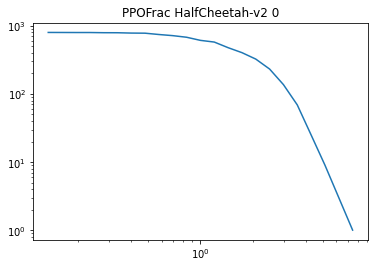

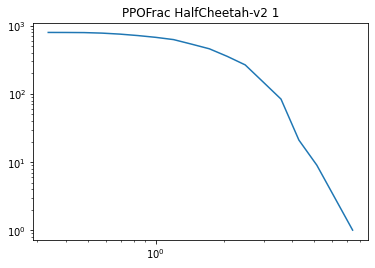

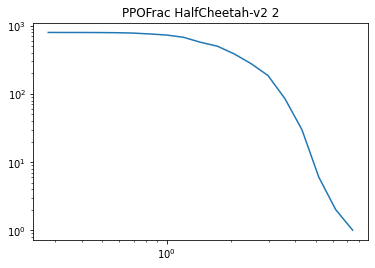

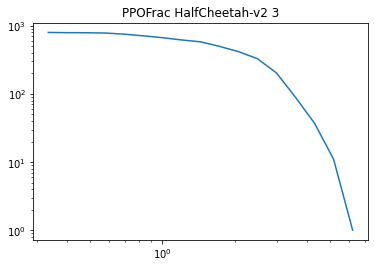

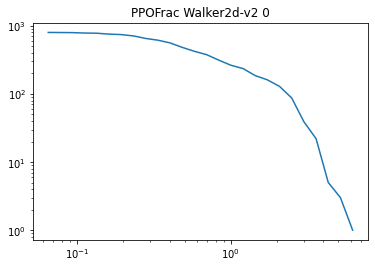

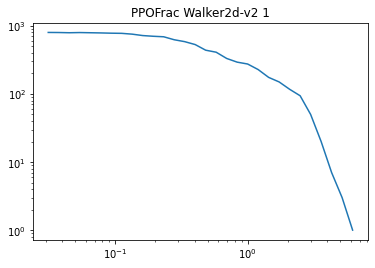

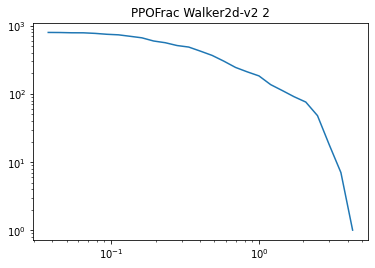

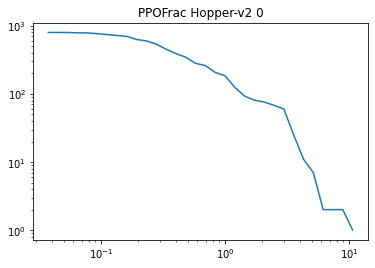

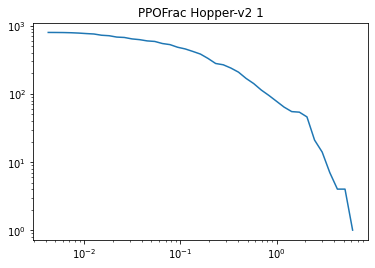

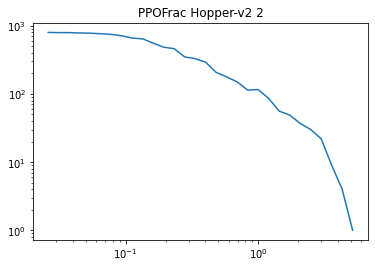

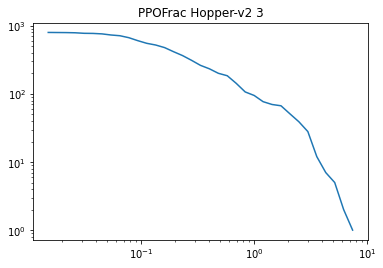

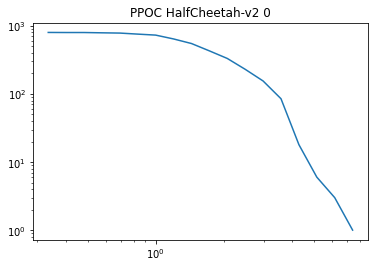

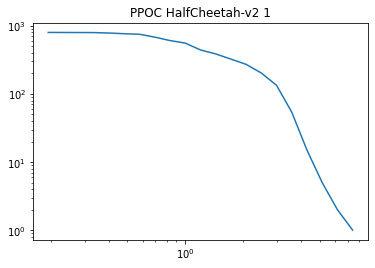

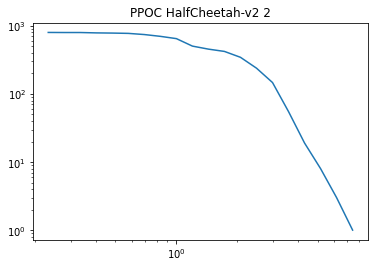

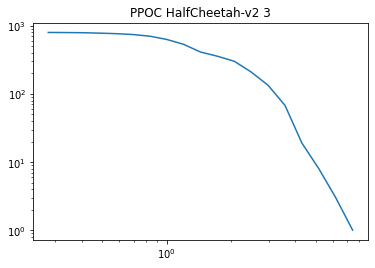

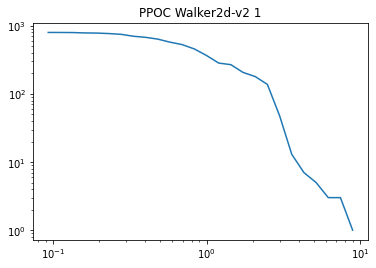

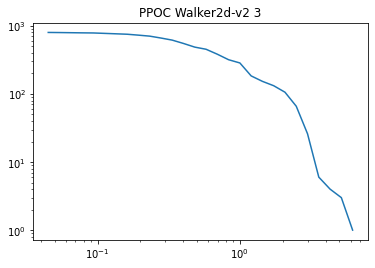

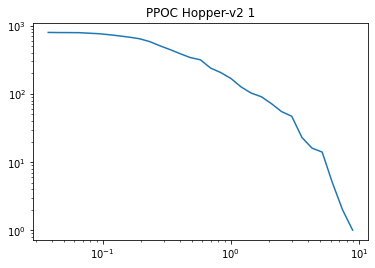

In [4]:
ep_length = 1000
ray.shutdown()
ray.init(log_to_driver=False)
#ray.init(logging_level="DEBUG")

for trainer_name in trainer_dict.keys():
    for env_name in trainer_dict[trainer_name].keys():
        trainer = None
        for i, checkpoint_path in enumerate(trainer_dict[trainer_name][env_name]):
            for j in range(num_runs):
                print(trainer_name, env_name, i, j)

                print(checkpoint_path)
                config, df = get_config_and_df(checkpoint_path)
                start = time.time()

                if trainer is None:
                    trainer = string_2_trainer[trainer_name](config)

                config["reuse_actors"] = True
                trainer.reset_config(config)
                trainer.restore(checkpoint_path)
                env = trainer.env_creator({})
                print("restore", time.time() - start); start = time.time()
                print(f"{checkpoint_path} restored")


                o,a,r,d = do_rollout_rllib(env, trainer, num_steps=ep_length,deterministic=True,return_on_done=True)
                #plt.plot(o)
                print("rollout",  time.time() - start);

                
                if d is False:
                    print("Fall detected")
                    rews.loc[trainer_name, env_name,i,j] = sum(r).item()
                    mdims.loc[trainer_name, env_name,i,j] = np.nan
                    cdims.loc[trainer_name, env_name,i,j] = np.nan
                    mdims_stable.loc[trainer_name, env_name,i,j] = np.nan
                elif d is True:
                    print("Fall not detected")

                    start = time.time()
                    o_norm = trainer.workers.local_worker().filters['default_policy'](o)
                    target = o[200:]
                    target = trainer.workers.local_worker().filters['default_policy'](target)
                    print("filter", time.time() - start); 

                    start = time.time()
                    rews.loc[trainer_name, env_name,i,j] = sum(r).item()
                    mdims.loc[trainer_name, env_name,i,j], cdims.loc[trainer_name, env_name,i,j], mesh_sizes, box_sizes = mesh_dim(target, init_d=1)
                    mdims_stable.loc[trainer_name, env_name,i,j] = mdim_stable(o_norm, a,r)
                    print("mdim", time.time() - start); start = time.time()
                    
                    #print(box_sizes, mesh_sizes)
                    
                    plt.figure()
                    plt.loglog(box_sizes,mesh_sizes)
                    plt.title(f"{trainer_name} {env_name} {i}")
                    
                    #print(trainer.workers.local_worker().filters['default_policy'])
                    #trainer.get_policy().observation_filter(trainer.env_creator({}).reset())
                else:
                    print("uhhhhhhhh--------------------------------------------------------------------------------")


In [5]:
for env_name in env_names:
    print("---------------------------------------------------------------------------------------------------------------------------")
    for trainer_name in trainer_dict.keys():

        mdim_mean = mdims.loc[{"trainer": trainer_name, "env":env_name}].mean().item()
        mdim_std = mdims.loc[{"trainer": trainer_name, "env":env_name}].std().item()
        
        cdim_mean = cdims.loc[{"trainer": trainer_name, "env":env_name}].mean().item()
        cdim_std = cdims.loc[{"trainer": trainer_name, "env":env_name}].std().item()
        
        sdim_mean = mdims_stable.loc[{"trainer": trainer_name, "env":env_name}].mean().item()
        sdim_std = mdims_stable.loc[{"trainer": trainer_name, "env":env_name}].std().item()
        
        rew_mean = rews.loc[{"trainer": trainer_name, "env":env_name}].mean().item()
        rew_std = rews.loc[{"trainer": trainer_name, "env":env_name}].std().item()


        print(f"{env_name:<15} - {trainer_name:<8} | mdim: {mdim_mean:<.3f} +- {mdim_std:<.3f} | cdim: {cdim_mean:<.3f} +- {cdim_std:<.3f} | sdim: {sdim_mean:<.3f} +- {sdim_std:<.3f} | rew: {rew_mean:<.3f} +- {rew_std:<.3f}")


---------------------------------------------------------------------------------------------------------------------------
HalfCheetah-v2  - PPOFrac  | mdim: 1.481 +- 0.242 | cdim: 6.712 +- 1.589 | sdim: 1.481 +- 0.242 | rew: 2549.067 +- 1559.442
HalfCheetah-v2  - PPOC     | mdim: 1.634 +- 0.133 | cdim: 7.091 +- 0.953 | sdim: 1.634 +- 0.133 | rew: 1618.882 +- 89.620
---------------------------------------------------------------------------------------------------------------------------
Walker2d-v2     - PPOFrac  | mdim: 0.920 +- 0.106 | cdim: 6.421 +- 1.215 | sdim: 0.920 +- 0.106 | rew: 4803.356 +- 1134.219
Walker2d-v2     - PPOC     | mdim: 1.198 +- 0.144 | cdim: 7.604 +- 0.439 | sdim: 1.198 +- 0.144 | rew: 3835.176 +- 1346.341
---------------------------------------------------------------------------------------------------------------------------
Hopper-v2       - PPOFrac  | mdim: 0.894 +- 0.154 | cdim: 5.180 +- 0.999 | sdim: 0.894 +- 0.154 | rew: 3493.768 +- 86.003
Hopper-v2   

In [6]:
mesh_sizes

[800,
 797,
 796,
 794,
 780,
 766,
 741,
 712,
 682,
 646,
 587,
 510,
 448,
 390,
 342,
 317,
 240,
 206,
 169,
 127,
 103,
 91,
 72,
 55,
 47,
 23,
 16,
 14,
 5,
 2,
 1]

In [7]:
# ray.shutdown()
# ray.init(log_to_driver=False)

In [8]:
# from matplotlib.pyplot import *

# trainer_name = 'PPOFrac'
# env_name = 'Hopper-v2'
# seed_num = 3
# checkpoint_path = trainer_dict[trainer_name][env_name][seed_num]
# config, df = get_config_and_df(checkpoint_path)
# trainer = string_2_trainer[trainer_name](config)
# trainer.restore(checkpoint_path)
# env = trainer.env_creator({})
# o,a,r,l = do_rollout_rllib(env, trainer, num_steps=1000, deterministic=True, render=True)

# o_norm = trainer.workers.local_worker().filters['default_policy'](o)
# target = o[200:]
# target = trainer.workers.local_worker().filters['default_policy'](target)


# ms = mdim_stable(o_norm,a,r)
# m, c, _, _ = mesh_dim(target, init_d=1e-6)


# plot(df['episode_reward_mean'])
# print(f"m:{m} c:{c} ms:{ms}")
# figure()
# plot(o);
# print(sum(r))

In [9]:
# sampled_act, _, out_dict = trainer.compute_action(o[0,:], full_fetch=True)
# means = out_dict['action_dist_inputs']
# means = means[:len(means)//2]
# print(sampled_kyact, means)


In [10]:
# gym.make("MinitaurBulletEnv-v0")

In [11]:
# env.observation_space.shape